## Query to get to get 5 yr forward and backward counts with CPC codes for biotechnology. 

In [61]:
QUERY = """
SELECT DISTINCT application.patent_id, application.date, citation_5.bkwdCitations_5,citation_5.fwrdCitations_5
FROM
    (SELECT  b.patent_id, b.bkwdCitations_5, f.fwrdCitations_5
      FROM 

        (SELECT 
          cited.patent_id,
          COUNT(*) as fwrdCitations_5
          FROM 
          `patents-public-data.patentsview.uspatentcitation` AS cited,
          `patents-public-data.patentsview.application` AS apps
        WHERE
          apps.country = 'US'
          AND cited.patent_id = apps.patent_id 
          AND cited.date >= apps.date AND SAFE_CAST(cited.date AS DATE) <= DATE_ADD(SAFE_CAST(apps.date AS DATE), INTERVAL 5 YEAR) -- get in 5year interval 
         GROUP BY 
         cited.patent_id) AS f,

       (SELECT 
          cited.patent_id,
          COUNT(*) as bkwdCitations_5
          FROM 
          `patents-public-data.patentsview.uspatentcitation` AS cited,
          `patents-public-data.patentsview.application` AS apps
        WHERE
          apps.country = 'US'
          AND cited.patent_id = apps.patent_id 
          AND cited.date < apps.date AND SAFE_CAST(cited.date AS DATE) >= DATE_SUB(SAFE_CAST(apps.date AS DATE), INTERVAL 5 YEAR) -- get in 5year interval 
         GROUP BY 
         cited.patent_id) AS b
      WHERE
      b.patent_id = f.patent_id AND b.bkwdCitations_5 IS NOT NULL AND f.fwrdCitations_5 IS NOT NULL) AS citation_5,
    `patents-public-data.patentsview.cpc_current` AS cpc, 
    `patents-public-data.patentsview.application` AS application
    WHERE cpc.patent_id = citation_5.patent_id AND application.patent_id = citation_5.patent_id
    AND (cpc.subsection_id IN ('C05', 'C07', 'C08', 'C09', 'C11', 'C12', 'C13', 'C25', 'C40')
      OR cpc.group_id in ('A01G', 'A01H', 'A61K', 'A61P', 'A61Q', 'B01F', 'B01J', 'B81B', 'B82B', 'B82Y','G01N', 'G16H'))
"""

## Set up environments for google big query python SDK

In [2]:
from google.cloud import bigquery
import os
import pandas as pd 
API_KEY_PATH = "/Users/jideofor/Documents/cs397/Patents-Research-abd8b4aaf0a8.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = API_KEY_PATH
PROJECT_ID = "patents-research-275923"

## Run query and generate descriptive stats

In [62]:
df = pd.read_gbq(QUERY, project_id=PROJECT_ID, dialect='standard', progress_bar_type='tqdm')


Downloading: 100%|██████████| 249642/249642 [00:09<00:00, 26307.42rows/s]


In [6]:
list(df)


['patent_id', 'date', 'bkwdCitations_5', 'fwrdCitations_5']

In [66]:
maskValid = (df['date'] < '2016-1-1')
df['date'] = pd.to_datetime(df['date'], errors="coerce",format="%Y-%m-%d")
df = df.loc[maskValid]


In [68]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.astype({'bkwdCitations_5': 'int32','fwrdCitations_5': 'int32' }).dtypes
df.describe(include='all', percentiles=[.25, .5, .75, .95,.99])


,patent_id,date,bkwdCitations_5,fwrdCitations_5
count,241435,241435,241435.00,241435.00
unique,241435,12161,nan,nan
top,3975384,1995-06-07 00:00:00,nan,nan
freq,1,710,nan,nan
first,NaN,1955-11-22 00:00:00,nan,nan
last,NaN,2015-12-31 00:00:00,nan,nan
mean,NaN,NaN,7.64,2.70
std,NaN,NaN,17.65,8.00
min,NaN,NaN,1.00,1.00
25%,NaN,NaN,2.00,1.00


For record keeping there are 245,192 unique observations. 

## Get trends plot of the trends in the number of patents released since 1995

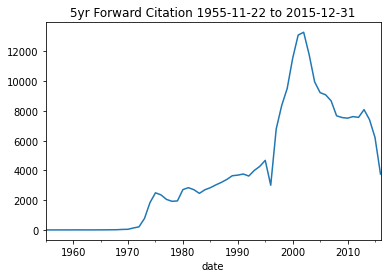

In [65]:
import matplotlib.pylab as plt

#maskEarly = (df['date'] > '1970-1-1') & (df['date'] <= '1980-1-1')
#maskLate = (df['date'] > '2010-1-1') & (df['date'] < '2016-1-1')
#maskValid = (df['date'] < '2016-1-1')

# Get the counts +
ax = df['date'].groupby(df.date.dt.to_period("Y")).agg('count').plot(title="5yr Forward Citation 1955-11-22 to 2015-12-31")
plt.show()


Getting the distribution of citations for two distince decades. 

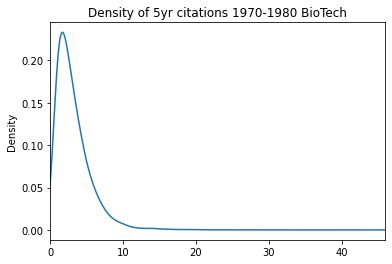

In [75]:
maskEarly = (df['date'] > '1970-1-1') & (df['date'] <= '1980-1-1')
df.loc[maskEarly]['bkwdCitations_5'].plot.kde(bw_method=0.3, xlim=(0,80), title="Density of 5yr citations 1970-1980 BioTech")

In [87]:
df.loc[maskEarly].describe(include='all', percentiles=[.25, .5, .75, .95,.99])



,patent_id,date,bkwdCitations_5,fwrdCitations_5
count,13776,13776,13776.00,13776.00
unique,13776,2012,nan,nan
top,4286393,1975-05-27 00:00:00,nan,nan
freq,1,30,nan,nan
first,NaN,1970-01-05 00:00:00,nan,nan
last,NaN,1979-12-31 00:00:00,nan,nan
mean,NaN,NaN,3.11,1.48
std,NaN,NaN,2.39,0.99
min,NaN,NaN,1.00,1.00
25%,NaN,NaN,1.00,1.00


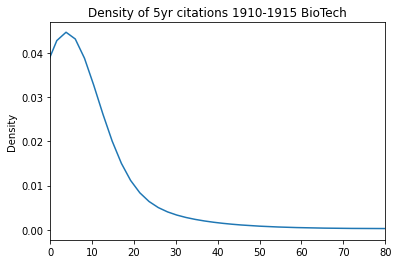

In [76]:
maskLate = (df['date'] > '2010-1-1') & (df['date'] < '2016-1-1')
df.loc[maskLate]['bkwdCitations_5'].plot.kde(bw_method=0.3, xlim=(0,80), title="Density of 5yr citations 2010-2015 BioTech")

In [83]:
df.loc[maskLate].describe(include='all', percentiles=[.25, .5, .75, .95,.99])



,patent_id,date,bkwdCitations_5,fwrdCitations_5
count,134284,134284,134284.00,134284.00
unique,134284,4409,nan,nan
top,6573235,1995-06-07 00:00:00,nan,nan
freq,1,710,nan,nan
first,NaN,1995-01-03 00:00:00,nan,nan
last,NaN,2009-12-31 00:00:00,nan,nan
mean,NaN,NaN,8.97,3.03
std,NaN,NaN,19.03,8.87
min,NaN,NaN,1.00,1.00
25%,NaN,NaN,2.00,1.00


Could be a product of the increased number of patents

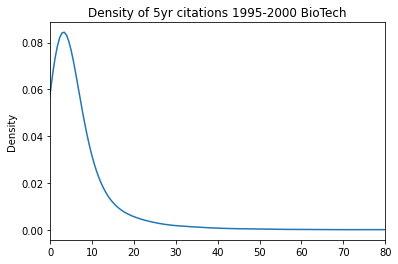

In [84]:
maskMedium = (df['date'] > '1995-1-1') & (df['date'] < '2000-1-1')
df.loc[maskMedium]['bkwdCitations_5'].plot.kde(bw_method=0.3, xlim=(0,80), title="Density of 5yr citations 1995-2000 BioTech")

In [85]:
df.loc[maskMedium].describe(include='all', percentiles=[.25, .5, .75, .95,.99])



,patent_id,date,bkwdCitations_5,fwrdCitations_5
count,32360,32360,32360.00,32360.00
unique,32360,1359,nan,nan
top,6322624,1995-06-07 00:00:00,nan,nan
freq,1,710,nan,nan
first,NaN,1995-01-03 00:00:00,nan,nan
last,NaN,1999-12-31 00:00:00,nan,nan
mean,NaN,NaN,6.71,2.47
std,NaN,NaN,10.37,3.77
min,NaN,NaN,1.00,1.00
25%,NaN,NaN,2.00,1.00
